[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sunnyswag/RL_in_Finance/blob/main/RL_in_Finance_Test.ipynb)
# RL in Finance(Test Cash Penalty) 

## 1、拉取 github 仓库，下载并导入相关包
&emsp;&emsp;运行流程：python setup.py -> pip install -r requirements.txt

In [1]:
!pip install git+https://github.com/sunnyswag/RL_in_Finance.git
!pip install git+https://github.com/quantopian/pyfolio.git

  Cloning https://github.com/sunnyswag/RL_in_Finance.git to /tmp/pip-req-build-h9d_rpd5
  Running command git clone -q https://github.com/sunnyswag/RL_in_Finance.git /tmp/pip-req-build-h9d_rpd5
     |████████████████████████████████| 215kB 7.2MB/s 
     |████████████████████████████████| 92kB 6.9MB/s 
     |████████████████████████████████| 153kB 13.3MB/s 
     |████████████████████████████████| 61kB 4.4MB/s 
     |████████████████████████████████| 133kB 14.0MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
  Created wheel for RL-in-Finance: filename=RL_in_Finance-0.1.0-cp37-none-any.whl size=45037 sha256=72c89af4a72f3782072137809de83f75a102c546320dfe1c0e4aa7c881543d13
  Stored in directory: /tmp/pip-ephem-wheel-cache-e_coahzu/wheels/2d/ec/a7/af97768a8d7077098dc0fcefc71a4ebcc7f5f1d72d245185b0
  Created wheel for pyfolio: filename=pyfolio-0.9.2-cp37-none-any.whl size=88667 sha256=9b93d99206a04baa7683898238788ccabd06fa3a8316cd6eaaa732c7d36b1d08
  Stored in directory: /root/.cac

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

%matplotlib inline
from utils import config
from utils.pull_data import Pull_data
from utils.preprocessors import FeatureEngineer, split_data
from utils.env_cash_penalty import StockTradingEnvCashpenalty
from utils.models import DRL_Agent
from utils.backtest import backtest_stats, backtest_plot, get_baseline
import itertools
import sys
sys.path.append("../RL_in_Finance")

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


## 2、下载数据

数据来源：Tushare API<br>
当前用到的数据：SSE_50 和 CSI_300<br>
数据量的大小：shape[2892 * n, 8]

In [3]:
stock_list = config.SSE_50
df = Pull_data(stock_list, save_data=False).pull_data()

--- 开始下载 ----
下载进度 : 20.0%
下载进度 : 40.0%
下载进度 : 60.0%
下载进度 : 80.0%
下载进度 : 100.0%
--- 下载完成 ----
DataFrame 的大小:  (114845, 8)


In [4]:
df.sort_values(['date', 'tic'], ignore_index=True).head()

,date,tic,open,high,low,close,volume,day
0,2009-01-05,600000.SH,2.7584,2.8115,2.7258,2.8013,503142.56,0
1,2009-01-05,600009.SH,9.4665,9.6505,9.4414,9.5836,52100.33,0
2,2009-01-05,600016.SH,1.6369,1.6487,1.6170,1.6448,947739.82,0
3,2009-01-05,600028.SH,3.1966,3.2461,3.1786,3.2371,361085.66,0
4,2009-01-05,600030.SH,9.2667,9.5705,9.1654,9.5502,818978.41,0


In [5]:
print("数据下载的时间区间为：{} 至 {}".format(config.Start_Date, config.End_Date))

数据下载的时间区间为：20090101 至 20210101


In [6]:
print("下载的股票列表为: ")
print(stock_list)

下载的股票列表为: 
['600000.SH', '600009.SH', '600016.SH', '600028.SH', '600030.SH', '600031.SH', '600036.SH', '600048.SH', '600050.SH', '600104.SH', '600196.SH', '600276.SH', '600309.SH', '600519.SH', '600547.SH', '600570.SH', '600585.SH', '600588.SH', '600690.SH', '600703.SH', '600745.SH', '600837.SH', '600887.SH', '600918.SH', '601012.SH', '601066.SH', '601088.SH', '601138.SH', '601166.SH', '601186.SH', '601211.SH', '601236.SH', '601288.SH', '601318.SH', '601319.SH', '601336.SH', '601398.SH', '601601.SH', '601628.SH', '601668.SH', '601688.SH', '601816.SH', '601818.SH', '601857.SH', '601888.SH', '603160.SH', '603259.SH', '603288.SH', '603501.SH', '603986.SH']


## 3、数据预处理

In [7]:
processed_df = FeatureEngineer(use_technical_indicator=True).preprocess_data(df)

成功添加技术指标
对当前时间段未上市的公司的所有行置零


In [8]:
print("技术指标列表: ")
print(config.TECHNICAL_INDICATORS_LIST)
print("技术指标数: {}个".format(len(config.TECHNICAL_INDICATORS_LIST)))

技术指标列表: 
['boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'macd', 'volume_20_sma', 'volume_60_sma', 'volume_120_sma', 'close_20_sma', 'close_60_sma', 'close_120_sma']
技术指标数: 12个


In [9]:
processed_df.head()

,date,tic,open,high,low,close,volume,day,boll_ub,boll_lb,rsi_30,cci_30,dx_30,macd,volume_20_sma,volume_60_sma,volume_120_sma,close_20_sma,close_60_sma,close_120_sma
0,2009-01-05,600000.SH,2.7584,2.8115,2.7258,2.8013,503142.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,503142.56,503142.56,503142.56,2.8013,2.8013,2.8013
1,2009-01-05,600009.SH,9.4665,9.6505,9.4414,9.5836,52100.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52100.33,52100.33,52100.33,9.5836,9.5836,9.5836
2,2009-01-05,600016.SH,1.6369,1.6487,1.6170,1.6448,947739.82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,947739.82,947739.82,947739.82,1.6448,1.6448,1.6448
3,2009-01-05,600028.SH,3.1966,3.2461,3.1786,3.2371,361085.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,361085.66,361085.66,361085.66,3.2371,3.2371,3.2371
4,2009-01-05,600030.SH,9.2667,9.5705,9.1654,9.5502,818978.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,818978.41,818978.41,818978.41,9.5502,9.5502,9.5502


In [10]:
train_data = split_data(processed_df, config.Start_Trade_Date, config.End_Trade_Date)
test_data = split_data(processed_df, config.End_Trade_Date, config.End_Test_Date)

In [11]:
print("训练数据的范围：{} 至 {}".format(config.Start_Trade_Date, config.End_Trade_Date))
print("测试数据的范围：{} 至 {}".format(config.End_Trade_Date, config.End_Test_Date))
print("训练数据的长度: {},测试数据的长度:{}".format(len(train_data), len(test_data)))
print("训练集数据 : 测试集数据: {} : {}".format(round(len(train_data)/len(test_data),1), 1))

训练数据的范围：2009-01-01 至 2019-01-01
测试数据的范围：2019-01-01 至 2021-01-01
训练数据的长度: 121550,测试数据的长度:24350
训练集数据 : 测试集数据: 5.0 : 1


In [12]:
train_data.head()

,date,tic,open,high,low,close,volume,day,boll_ub,boll_lb,rsi_30,cci_30,dx_30,macd,volume_20_sma,volume_60_sma,volume_120_sma,close_20_sma,close_60_sma,close_120_sma
0,2009-01-05,600000.SH,2.7584,2.8115,2.7258,2.8013,503142.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,503142.56,503142.56,503142.56,2.8013,2.8013,2.8013
0,2009-01-05,600009.SH,9.4665,9.6505,9.4414,9.5836,52100.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52100.33,52100.33,52100.33,9.5836,9.5836,9.5836
0,2009-01-05,600016.SH,1.6369,1.6487,1.6170,1.6448,947739.82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,947739.82,947739.82,947739.82,1.6448,1.6448,1.6448
0,2009-01-05,600028.SH,3.1966,3.2461,3.1786,3.2371,361085.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,361085.66,361085.66,361085.66,3.2371,3.2371,3.2371
0,2009-01-05,600030.SH,9.2667,9.5705,9.1654,9.5502,818978.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,818978.41,818978.41,818978.41,9.5502,9.5502,9.5502


## 4、初始化环境

**state_space 由四部分组成 :** <br>
1. 当天的资金量
2. 每只股票当天的收盘价
3. 每只股票当天的持仓量
4. 股票数 * 技术指标数<br>
5. 当天成交量

**reward 的计算方式：**<br>
* reward 交易前的总资产-当天交易后的总资产 = 当天交易的手续费
* TODO：待改进

**action_space 的空间：**<br>
  * actions ∈[-100, 100]
  * 正数表示买入，负数表示卖出，0表示不进行买入卖出操作
  * 绝对值表示买入卖出的数量

In [13]:
# stock_dimension = len(df.tic.unique())
# state_space = 1 + 2*stock_dimension + \
#     len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension + stock_dimension
# print("stock_dimension: {}, state_space: {}".format(stock_dimension, state_space))

stock_dimension: 50, state_space: 751


In [14]:
# 初始化环境的参数
information_cols = config.TECHNICAL_INDICATORS_LIST + ["close", "day"]

e_train_gym = StockTradingEnvCashpenalty(df = train,initial_amount = 1e6,hmax = 5000, 
                                turbulence_threshold = None, 
                                currency='￥',
                                buy_cost_pct=3e-3,
                                sell_cost_pct=3e-3,
                                cash_penalty_proportion=0.2,
                                cache_indicator_data=True,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500, 
                                random_start = True)

e_trade_gym = StockTradingEnvCashpenalty(df = trade,initial_amount = 1e6,hmax = 5000, 
                                turbulence_threshold = None, 
                                currency='￥',
                                buy_cost_pct=3e-3,
                                sell_cost_pct=3e-3,
                                cash_penalty_proportion=0.2,
                                cache_indicator_data=True,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500, 
                                random_start = False)

In [15]:
# 对环境进行测试
observation = e_train_gym.reset() # 初始化环境，observation为环境状态
count = 0
total_reward = 0
for t in range(10):
  action = e_train_gym.action_space.sample() # 随机采样动作
  observation, reward, done, info = e_train_gym.step(action) # 与环境交互，获得下一个state的值
  total_reward += reward
  if done:             
      break
  count+=1
  time.sleep(0.2)      #每次等待 0.2s
print("observation: ", observation)
print("e_train_gym.cost: ", e_train_gym.cost)
print("reward: {}, done: {}".format(total_reward, done))

observation:  [975641.1483029003, 3.2587, 10.5955, 1.7518, 3.5118, 10.5073, 3.3248, 6.5186, 3.1604, 4.427, 2.8512, 6.5327, 3.5638, 5.4781, 63.1248, 5.7194, 3.4616, 7.31, 2.9807, 1.8566, 0.9691, 0.0, 8.7087, 1.2094, 0.0, 0.0, 0.0, 10.8021, 0.0, 4.274, 7.8589, 0.0, 0.0, 0.0, 12.5139, 0.0, 0.0, 2.028, 10.5996, 16.7811, 0.0, 0.0, 0.0, 0.0, 7.7493, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 133, 51, 46, 417, 313, 0, 250, 132, 56, 0, 58, 110, 101, 47, 14, 0, 0, 320, 6, 9, 167, 101, 0, 0, 0, 0, 296, 0, 103, 0, 0, 0, 0, 245, 0, 0, 86, 112, 152, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 3.29030605610415, 11.158052250161413, 1.7506966619148174, 3.4629588940085694, 10.615014793023931, 3.4648652199996115, 6.567314521607222, 3.175544225375469, 4.771290487123888, 2.944647651106249, 6.705733731264593, 3.693131267631593, 5.698170639583509, 68.74835077321057, 6.15819869140558, 3.600371485962766, 7.7084983780785885, 3.0302467355334706, 1.9052412830693457, 1.0368484735782546, 0.0, 9.029770434991562, 1.2332554839997247, 0.0, 

In [16]:
# for this example, let's do multiprocessing with n_cores-2
import multiprocessing

n_cores = multiprocessing.cpu_count() - 2
print(f"using {n_cores} cores")

#this is our training env. It allows multiprocessing
env_train, _ = e_train_gym.get_multiproc_env(n = n_cores)
# env_train, _ = e_train_gym.get_sb_env()

#this is our observation environment. It allows full diagnostics
env_trade, _ = e_trade_gym.get_sb_env()

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## 5、开始训练

所用到的框架：stable_baseline3

In [17]:
# from torch.nn import Softsign, ReLU
ppo_params ={'n_steps': 256, 
             'ent_coef': 0.0, 
             'learning_rate': 0.000005, 
             'batch_size': 1024, 
            'gamma': 0.99}

policy_kwargs = {
#     "activation_fn": ReLU,
    "net_arch": [1024 for _ in range(10)], 
#     "squash_output": True
}

model = agent.get_model("ppo",  
                        model_kwargs = ppo_params, 
                        policy_kwargs = policy_kwargs, verbose = 0)

# model = model.load("scaling_reward.model", env = env_train)

{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 2000, 'ent_coef': 'auto_0.1'}
Using cpu device


In [18]:
model.learn(total_timesteps = 5000000, 
            eval_env = env_trade, 
            eval_freq = 500,
            log_interval = 1, 
            tb_log_name = 'env_cashpenalty_highlr',
            n_eval_episodes = 1)    

Logging to tensorboard_log/sac/sac_1
----------------------------------
| environment/        |          |
|    portfolio_value  | 5.67e+06 |
|    total_cost       | 1e+03    |
|    total_reward     | 4.67e+06 |
|    total_reward_pct | 467      |
|    total_trades     | 35271    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 31       |
|    time_elapsed     | 307      |
|    total timesteps  | 9724     |
| train/              |          |
|    actor_loss       | 8.54e+04 |
|    critic_loss      | 3.11e+07 |
|    ent_coef         | 0.213    |
|    ent_coef_loss    | 903      |
|    learning_rate    | 0.0001   |
|    n_updates        | 7723     |
----------------------------------
天数: 2430天, episode: 10
开始时的总资产: 1000000.0
结束时的总资产: 5670614.18
总奖励值: 4670614.18
总的手续费: 1002.76
总的交易次数: 35271
Sharpe: 0.597
----------------------------------
| environment/        |          |
|    portfolio_value  | 5.67e+06 |
|    total_cost       | 1e+03    |
|

KeyboardInterrupt: ignored

## 6、测试

In [19]:
df_account_value, df_actions = DRL_Agent.DRL_prediction(
    model=model, 
    environment = e_trade_gym)

回测完成!


In [20]:
print("回测的时间窗口：{} 至 {}".format(config.End_Trade_Date, config.End_Test_Date))

回测的时间窗口：2019-01-01 至 2021-01-01


In [21]:
df_account_value.to_csv("df_account_value.csv", index=False)
print("查看日账户净值")
print("开始: ")
print(df_account_value.head())
print("")
print("结束: ")
print(df_account_value.tail())

查看日账户净值
开始: 
         date  account_value
0  2019-01-02   1.000000e+06
1  2019-01-02   9.998894e+05
2  2019-01-03   9.982858e+05
3  2019-01-04   1.002786e+06
4  2019-01-07   1.004789e+06

结束: 
           date  account_value
482  2020-12-24   2.959306e+06
483  2020-12-25   2.963378e+06
484  2020-12-28   2.998358e+06
485  2020-12-29   3.001630e+06
486  2020-12-30   3.088108e+06


In [22]:
print("查看每日所作的交易")
df_actions.to_csv("df_actions.csv", index=False)
df_actions.tail()

查看每日所作的交易


,600000.SH,600009.SH,600016.SH,600028.SH,600030.SH,600031.SH,600036.SH,600048.SH,600050.SH,600104.SH,600196.SH,600276.SH,600309.SH,600519.SH,600547.SH,600570.SH,600585.SH,600588.SH,600690.SH,600703.SH,600745.SH,600837.SH,600887.SH,600918.SH,601012.SH,601066.SH,601088.SH,601138.SH,601166.SH,601186.SH,601211.SH,601236.SH,601288.SH,601318.SH,601319.SH,601336.SH,601398.SH,601601.SH,601628.SH,601668.SH,601688.SH,601816.SH,601818.SH,601857.SH,601888.SH,603160.SH,603259.SH,603288.SH,603501.SH,603986.SH
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 7、回测

In [23]:
print("---------------------获取回测结果---------------------")
pref_stats_all = backtest_stats(account_value=df_account_value)

# perf_stats_all = pd.DataFrame(perf_stats_all)
# now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
# perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

---------------------获取回测结果---------------------
Annual return          0.792228
Cumulative returns     2.088108
Annual volatility      0.274455
Sharpe ratio           2.270191
Calmar ratio           4.452783
Stability              0.946991
Max drawdown          -0.177917
Omega ratio            1.490167
Sortino ratio          3.447888
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.293394
Daily value at risk   -0.032106
dtype: float64


In [24]:
# 获取 baseline 的结果
print("---------------------获取baseline结果---------------------")
baseline_df = get_baseline(config.SSE_50_INDEX, 
              start="20190101",
              end="20210101")
baseline_stats = backtest_stats(baseline_df, value_col_name='close')

---------------------获取baseline结果---------------------
--- 开始下载 ----
--- 下载完成 ----
DataFrame 的大小:  (487, 8)
Annual return          0.271107
Cumulative returns     0.589776
Annual volatility      0.189096
Sharpe ratio           1.366667
Calmar ratio           1.487275
Stability              0.618053
Max drawdown          -0.182284
Omega ratio            1.286287
Sortino ratio          1.953108
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.078570
Daily value at risk   -0.022798
dtype: float64


In [26]:
# 删除 df_account_value 中重复的行
df_account_value.drop(df_account_value.index[1], inplace=True)

In [27]:
baseline_df.head(10)

,date,tic,open,high,low,close,volume,day
0,2019-01-02,000016.SH,2262.7908,2298.1805,2301.0552,2252.7479,20880697.0,2
1,2019-01-03,000016.SH,2269.2430,2259.4825,2287.7778,2253.9433,18895240.0,3
2,2019-01-04,000016.SH,2314.6466,2252.7449,2316.3528,2249.3658,25900596.0,4
3,2019-01-07,000016.SH,2314.3193,2329.0316,2331.6031,2306.8979,25278948.0,0
4,2019-01-08,000016.SH,2305.1708,2312.1705,2312.1705,2298.9548,18131160.0,1
5,2019-01-09,000016.SH,2332.7192,2320.9119,2360.3601,2318.4352,28747596.0,2
6,2019-01-10,000016.SH,2331.8507,2333.2162,2345.3313,2321.3049,22280507.0,3
7,2019-01-11,000016.SH,2354.4987,2342.0236,2360.0609,2334.9145,18417693.0,4
8,2019-01-14,000016.SH,2331.1358,2350.2560,2354.3082,2330.0042,16462252.0,0
9,2019-01-15,000016.SH,2378.3696,2337.7021,2380.5995,2332.4095,22466336.0,1


---------------------Plot---------------------
和 000016.SH 指数进行比较
--- 开始下载 ----
--- 下载完成 ----
DataFrame 的大小:  (487, 8)


Start date,2019-01-02
End date,2020-12-30
Total months,23
,Backtest
Annual return,79.438%
Cumulative returns,208.811%
Annual volatility,27.473%
Sharpe ratio,2.27
Calmar ratio,4.46
Stability,0.95
Max drawdown,-17.792%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.79,2020-02-24,2020-03-23,2020-05-06,53
1,11.52,2020-07-13,2020-10-27,2020-12-29,122
2,11.23,2019-04-24,2019-06-06,2019-06-21,43
3,7.92,2020-01-22,2020-02-03,2020-02-13,17
4,6.93,2019-11-19,2019-11-29,2020-01-10,39


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


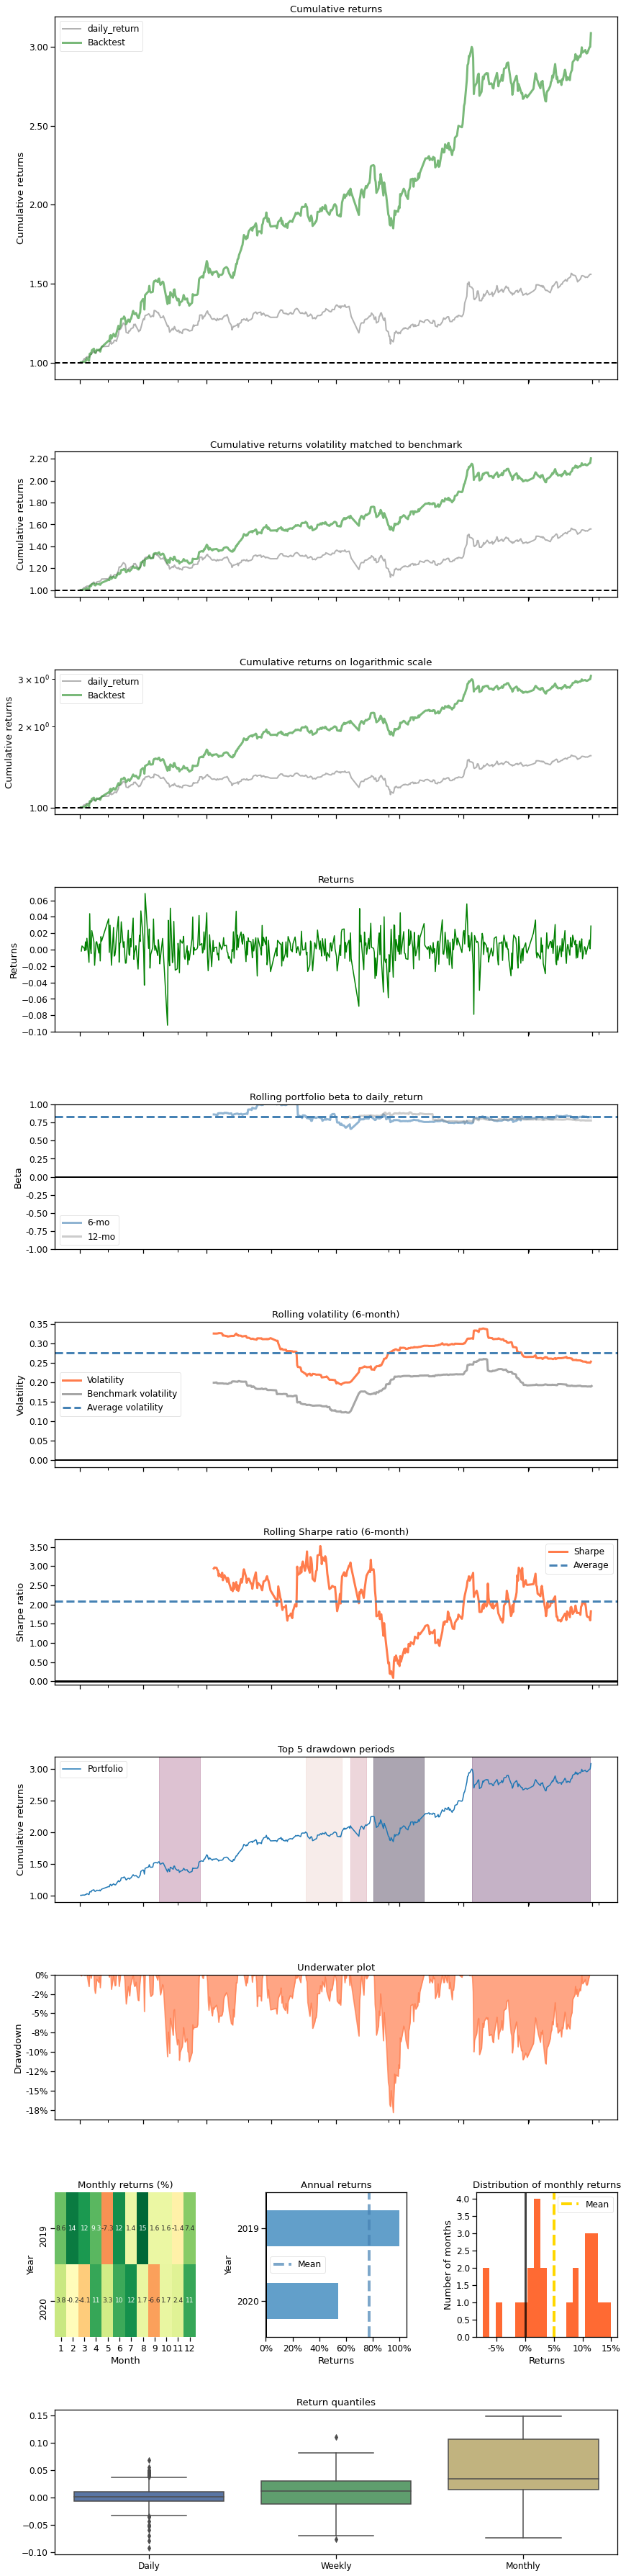

In [28]:
print("---------------------Plot---------------------")
print("和 {} 指数进行比较".format(config.SSE_50_INDEX[0]))
%matplotlib inline
backtest_plot(df_account_value,
        baseline_start="20190101",
        baseline_end="20210101",
        baseline_ticker=config.SSE_50_INDEX,
      )